# Lab 3

## Global Setup

In [2]:
from pathlib import Path
from functools import partial

from lab3.datasets import (
    PatchDatasetPostPad, CroppedDataset, AugmentedDataset,
    make_pixel_dataset, flip_and_rotate, split_dataset,
)
from lab3.models import MLPClassifier, CNNClassifier, TransferResNetClassifier, UNetClassifier
from lab3.utils import (
    read_data, read_info, display_image_and_label,
    train_evaluate_sklearn_classifier, train_evaluate_lit_classifier,
    predict_image_cnn, predict_image_unet, predict_all_images, get_latest_checkpoint,
)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import TensorDataset, ConcatDataset
import pytorch_lightning as pl

In [3]:
pl.utilities.seed.seed_everything(42)
rgb = (23, 11, 7)
info_path = 'hyrank_info.csv'
train_x_paths = [
    'HyRANK_satellite/TrainingSet/Dioni.tif',
    'HyRANK_satellite/TrainingSet/Loukia.tif',
]
train_y_paths = [
    'HyRANK_satellite/TrainingSet/Dioni_GT.tif',
    'HyRANK_satellite/TrainingSet/Loukia_GT.tif'
]
validation_x_paths = [
    'HyRANK_satellite/ValidationSet/Erato.tif',
    'HyRANK_satellite/ValidationSet/Kirki.tif',
    'HyRANK_satellite/ValidationSet/Nefeli.tif',
]
output_dir = Path('output')
output_dir.mkdir(exist_ok=True)
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'

Global seed set to 42


## Load the training images and their info

In [4]:
images, label_images = read_data(train_x_paths, train_y_paths)
info = read_info(info_path)
class_names = info['name']
colors = info['color']
cmap = mpl.colors.ListedColormap(info['color'])
norm = mpl.colors.BoundaryNorm(np.arange(-1, 14+1), ncolors=15)
train_evaluate_sklearn_classifier = partial(train_evaluate_sklearn_classifier, class_names=class_names[1:])
train_evaluate_lit_classifier = partial(train_evaluate_lit_classifier, class_names=class_names[1:], accelerator=accelerator)

/home/konstantinos/miniconda3/envs/geospatial/lib/python3.10/site-packages/rasterio/__init__.py:277: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


## Plot the training images

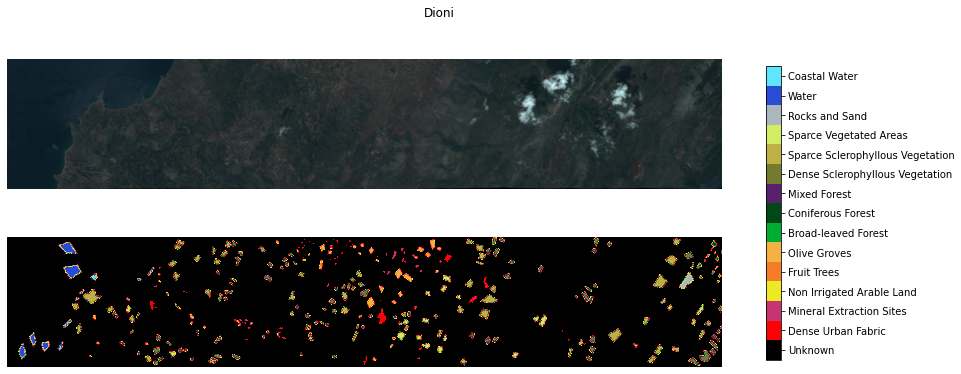

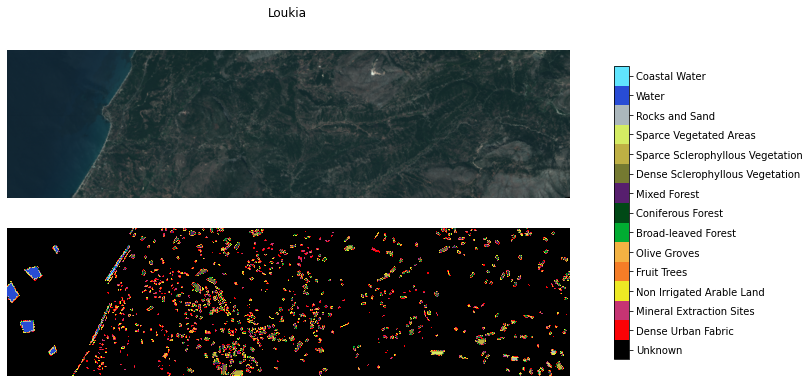

In [5]:
for image, label, path in zip(images, label_images, train_x_paths):
    path = Path(path)
    display_image_and_label(
        image=image, label=label,
        cmap=cmap, norm=norm, class_names=class_names, rgb=rgb, title=path.stem,
    )
    plt.savefig(output_dir / path.with_suffix('.png').name)

# Set up the datasets

In [6]:
# Scikit-Learn Dataset
x_pixels, y_pixels = make_pixel_dataset(images, label_images)
x_pixels_train, x_pixels_test, y_pixels_train, y_pixels_test = train_test_split(x_pixels, y_pixels, test_size=0.3)

# MLP Dataset
pixel_dataset = TensorDataset(torch.from_numpy(x_pixels), torch.from_numpy(y_pixels))
pixel_dataset_train, pixel_dataset_val, pixel_dataset_test = split_dataset(pixel_dataset, train_size=0.7, test_size=0.15)

# CNN Dataset
patch_dataset = ConcatDataset([
        PatchDatasetPostPad(image, label_image, patch_size=15)
        for image, label_image in zip(images, label_images)
])
patch_dataset_train, patch_dataset_val, patch_dataset_test = split_dataset(patch_dataset, train_size=0.7, test_size=0.15)
patch_dataset_train_aug = AugmentedDataset(patch_dataset_train, flip_and_rotate)

# ResNet dataset   
rgb_dataset = ConcatDataset([
    PatchDatasetPostPad(image, label_image, patch_size=15, channels=rgb)
    for image, label_image in zip(images, label_images)
])
rgb_dataset_train, rgb_dataset_val, rgb_dataset_test = split_dataset(rgb_dataset, train_size=0.7, test_size=0.15)
rgb_dataset_train_aug = AugmentedDataset(rgb_dataset_train, flip_and_rotate)

# UNet dataset (no overlap).
cropped_dataset = ConcatDataset([
    CroppedDataset(image, label_image, crop_size=64, stride=64, use_padding=True)  
    for image, label_image in zip(images, label_images)
])
cropped_dataset_train, cropped_dataset_val, cropped_dataset_test = split_dataset(cropped_dataset, train_size=0.7, test_size=0.15)
cropped_dataset_train_aug = AugmentedDataset(cropped_dataset_train, transform=flip_and_rotate, apply_on_target=True)

# UNet dataset (overlap). No split. This dataset is (64/16)**2 = 16 times largers compared to the no overlap one.
cropped_dataset_overlap = ConcatDataset([
    CroppedDataset(image, label_image, crop_size=64, stride=16, use_padding=True)
    for image, label_image in zip(images, label_images)
])
cropped_dataset_overlap_aug = AugmentedDataset(cropped_dataset_overlap, transform=flip_and_rotate, apply_on_target=True)

## Train and evaluate


Training SVM...


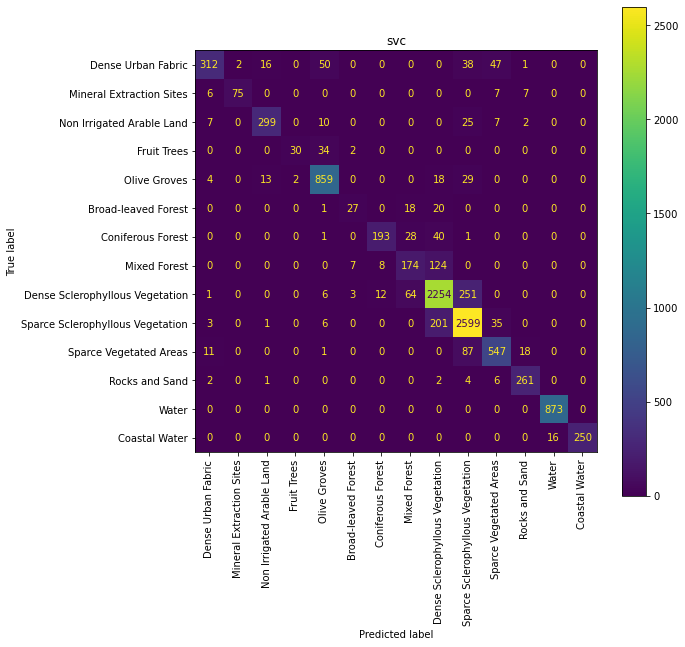

In [7]:
# SVM
print('\nTraining SVM...')
train_evaluate_sklearn_classifier(
    make_pipeline(StandardScaler(), SVC(C=1.0, kernel='rbf')),
    x_pixels_train, x_pixels_test, y_pixels_train, y_pixels_test, output_dir=output_dir/'svm'
)

In [ ]:
# Random Forest
print('\nTraining Random Forest...')
train_evaluate_sklearn_classifier(
    RandomForestClassifier(n_estimators=100),
    x_pixels_train, x_pixels_test, y_pixels_train, y_pixels_test, output_dir=output_dir/'randomforest'
)

In [ ]:
# MLP
print('\nTraining MLP...')
train_evaluate_lit_classifier(
    MLPClassifier(176, 14, lr=1e-3, weight_decay=1e-5),
    pixel_dataset_train, pixel_dataset_val, pixel_dataset_test,
    max_epochs=2, batch_size=512, output_dir=output_dir/'mlp', 
    # max_epochs=300, batch_size=512, output_dir=output_dir/'mlp', 
)

In [ ]:
# CNN
print('\nTraining CNN...')
train_evaluate_lit_classifier(
    CNNClassifier(176, 14, lr=1e-3),
    patch_dataset_train_aug, patch_dataset_val, patch_dataset_test,
    max_epochs=2, batch_size=64, output_dir=output_dir/'cnn',
    # max_epochs=200, batch_size=64, output_dir=output_dir/'cnn',
)

In [ ]:
# ResNet
print('\nTraining ResNet...')
train_evaluate_lit_classifier(
    TransferResNetClassifier(14, freeze_head=False, lr=1e-3),
    rgb_dataset_train_aug, rgb_dataset_val, rgb_dataset_test,
    max_epochs=2, batch_size=128, output_dir=output_dir/'resnet',
    # max_epochs=200, batch_size=256, output_dir=output_dir/'resnet',
)

In [ ]:
# UNet
print('\nTraining U-Net...')
train_evaluate_lit_classifier(
    UNetClassifier(176, 14, ignore_index=-1, lr=1e-3),
    cropped_dataset_train_aug, cropped_dataset_val, cropped_dataset_test,
    max_epochs=2, batch_size=8, ignore_index=-1, output_dir=output_dir/'unet',
    # max_epochs=500, batch_size=16, ignore_index=-1, output_dir=output_dir/'unet',
)

## Train on all the data and make predictions on the unlabeled images

### CNN All

In [ ]:
print('\nTraining CNN on all the data')
train_evaluate_lit_classifier(
    CNNClassifier(176, 14, lr=1e-3),
    patch_dataset_train_aug, None, None,
    max_epochs=1, batch_size=64, output_dir=output_dir/'cnn_all',
    # max_epochs=200, batch_size=64, output_dir=output_dir/'cnn_all',
)

In [ ]:
cnn = CNNClassifier.load_from_checkpoint(get_latest_checkpoint(output_dir/'cnn_all'))
print('\nPredicting on the unlabeled images')
predict_all_images(
    predict_fn=predict_image_cnn, model=cnn, suffix='_cnn', paths=validation_x_paths, batch_size=64,
    cmap=cmap, norm=norm, class_names=class_names, rgb=rgb, accelerator=accelerator,
    output_dir=output_dir/'cnn_all'/'predictions'
)
del cnn

### UNet all (with overlap)

In [ ]:
print('\nTraining UNet on all the data (allowing overlap)')
train_evaluate_lit_classifier(
    UNetClassifier(176, 14, ignore_index=-1, lr=1e-3),
    cropped_dataset_overlap_aug, None, None,
    max_epochs=1, batch_size=8, ignore_index=-1, output_dir=output_dir/'unet_all',
    # max_epochs=400, batch_size=16, ignore_index=-1, output_dir=output_dir/'unet_all',
)

In [ ]:
unet = UNetClassifier.load_from_checkpoint(get_latest_checkpoint(output_dir/'unet_all'))
print('\nPredicting on the unlabeled images')
predict_all_images(
    predict_fn=predict_image_unet, model=unet, suffix='_unet', paths=validation_x_paths, batch_size=8,
    cmap=cmap, norm=norm, class_names=class_names, rgb=rgb, accelerator=accelerator,
    output_dir=output_dir/'unet_all'/'predictions',
)

## Commentary

TRANSFORMS WILL GIVE YOU "WORSE" RESULTS IN THIS DATASET!
If for example there's forest at the top of the (entire) image,
and below the forest, it's all urban,
then rotating a patch of it will produce an image that doesn't exist in the dataset
and it would not help us predict other patches from the Same image.
It's all because the train and the test set are very dependent on one another

Using sliding window with stride equal to window size
so that no part from the training images exist in the validation images.
If overlap is allowed both train and validation accuracy reach ~100%,
but without overlap, validation accuracy drops to about 80%!
For example consider a test image with a city in its center,
and that city appearing in the corners of some training images.

Patch wise models do well because of overlap. Two neighboring pixels
produce essentially indentical patches, while they are also very likely
to have the same labels die to local "continuity" of the image.
If one of these two pixel is in the train set and the other is in the test set, then we have huge overlap.

Element wise models also perform really well because of local image "continuity".

Of all the models, only the segmentation model with no overlap
is the one that it test somewhat realistically.